In [1]:
# update the git
! git add  .
! git commit -m "From Mac"
! git push

[master 968359cd] From Mac
 2 files changed, 402 insertions(+), 63 deletions(-)
Counting objects: 6, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 219.71 KiB | 12.92 MiB/s, done.
Total 6 (delta 4), reused 0 (delta 0)
remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
To https://github.com/JaeDukSeo/Daily-Neural-Network-Practice-2
   2817993c..968359cd  master -> master


In [2]:
# import library
import tensorflow as tf
import matplotlib 
matplotlib.use('Agg')
%matplotlib inline
import numpy as np
import sys, os,cv2
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from skimage.transform import resize
from scipy.misc import imread
from imgaug import augmenters as iaa
import nibabel as nib
import imgaug as ia
from scipy.ndimage import zoom
from sklearn.utils import shuffle
import matplotlib.animation as animation

plt.style.use('seaborn-white')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.random.seed(6278)
tf.set_random_seed(6728)
ia.seed(6278)

# Generate training data
import tensorflow as tf
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.examples.tutorials.mnist import input_data
# ========= choice of library ====

In [3]:
# get the fashion mnist data set
mnist = input_data.read_data_sets('../../Dataset/MNIST/', one_hot=True)
x_data, train_label, y_data, test_label = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels
x_data_added,x_data_added_label = mnist.validation.images,mnist.validation.labels
x_data = x_data.reshape(-1, 28, 28, 1)  # 28x28x1 input img
y_data = y_data.reshape(-1, 28, 28, 1)  # 28x28x1 input img
x_data_added = x_data_added.reshape(-1, 28, 28, 1)
x_data = np.vstack((x_data,x_data_added))
train_label = np.vstack((train_label,x_data_added_label))

train_batch = np.zeros((5000,28,28,1))
test_batch = np.zeros((10000,28,28,1))
for x in range(5000):
    train_batch[x,:,:,:] = np.expand_dims(resize(x_data[x,:,:,0],(28,28)),axis=3)

# print out the data shape and the max and min value
print(train_batch.shape)
print(train_batch.max())
print(train_batch.min())
print(train_label.shape)
print(train_label.max())
print(train_label.min())
print(test_batch.shape)
print(test_batch.max())
print(test_batch.min())
print(test_label.shape)
print(test_label.max())
print(test_label.min())

Extracting ../../Dataset/MNIST/train-images-idx3-ubyte.gz
Extracting ../../Dataset/MNIST/train-labels-idx1-ubyte.gz
Extracting ../../Dataset/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../../Dataset/MNIST/t10k-labels-idx1-ubyte.gz


/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  


(5000, 28, 28, 1)
1.0
0.0
(60000, 10)
1.0
0.0
(10000, 28, 28, 1)
0.0
0.0
(10000, 10)
1.0
0.0


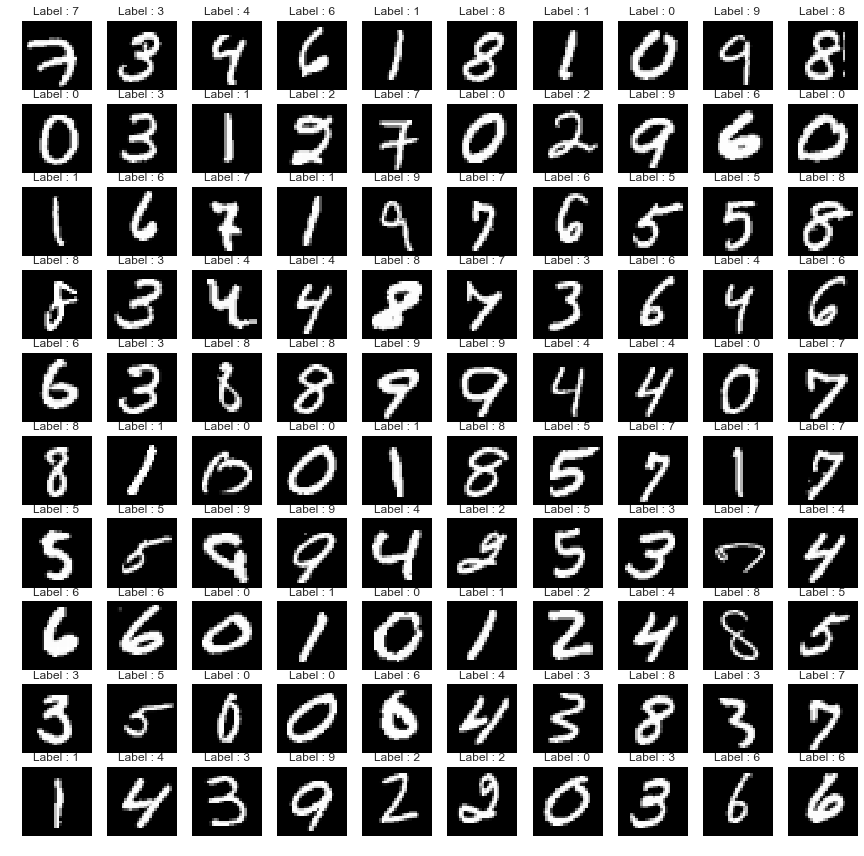

In [4]:
# show small amount of fashion
fig=plt.figure(figsize=(15, 15))
columns = 10 ; rows = 10
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(train_batch[i-1]),cmap='gray')
    plt.axis('off')
    plt.title("Label : "+str(np.argmax(train_label[i-1])))
plt.show()

In [43]:
# import all of the layers
def tf_elu(x):
    """ Exponential Linear Unit based on the ICCV 2015 paper
    https://arxiv.org/pdf/1511.07289.pdf

    Parameters
    ----------
    x : float
        The floating point number that is going to be applied to the ELU activation.

    Returns
    -------
    float
        Data with the same dimensions as the input after ELU

    """
    return tf.nn.elu(x)
def d_tf_elu(x):
    """Derivative of the Exponential Linear Unit base on the ICCV 2015 paper
    https://arxiv.org/pdf/1511.07289.pdf

    Parameters
    ----------
    x : type
        Description of parameter `x`.

    Returns
    -------
    type
        Description of returned object.

    """

    return tf.cast(tf.greater(x,0),tf.float32)  + (tf_elu(tf.cast(tf.less_equal(x,0),tf.float32) * x) + 1.0)

def tf_identiy(x): return x

def tf_relu(x): return tf.nn.relu(x)
def d_tf_relu(x): return tf.cast(tf.greater(x,0.0),tf.float32)

def tf_lrelu(x): return tf.nn.leaky_relu(x,alpha=0.85)
def d_tf_lrelu(x): return tf.cast(tf.greater(x,0),tf.float32) + tf.cast(tf.less_equal(x,0),tf.float32) * 0.85

def tf_tanh(x): return tf.nn.tanh(x)
def d_tf_tanh(x): return 1 - tf_tanh(x) ** 2

def tf_sigmoid(x): return tf.nn.sigmoid(x)
def d_tf_sigmoid(x): return tf_sigmoid(x) * (1.0-tf_sigmoid(x))

def tf_atan(x): return tf.atan(x)
def d_tf_atan(x): return 1.0/(1.0 + x**2)

def tf_iden(x): return x
def d_tf_iden(x): return 1.0

def tf_softmax(x): return tf.nn.softmax(x)
def softabs(x): return tf.sqrt(x ** 2 + 1e-20)

def tf_logcosh(x): return tf.log(tf.cosh(x))
def d_tf_logcosh(x): return tf.tanh(x)

class FNN():

    def __init__(self,inc,outc,act=tf_elu,d_act=d_tf_elu,special_init=False,which_reg=0.0):
        if special_init:
            interval = np.sqrt(6.0 / (inc + outc + 1.0))
            self.w = tf.Variable(tf.random_uniform(shape=(inc, outc),minval=-interval,maxval=interval,dtype=tf.float32,seed=2))
            self.b = tf.Variable(tf.random_uniform(shape=(outc),     minval=-interval,maxval=interval,dtype=tf.float32,seed=2))
        else:
            self.w = tf.Variable(tf.random_normal([inc,outc], stddev=0.05,seed=2,dtype=tf.float32))
            self.b = tf.Variable(tf.random_normal([outc],     stddev=0.05,seed=2,dtype=tf.float32))
        self.m,self.v     = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.m_b,self.v_b = tf.Variable(tf.zeros_like(self.b)),tf.Variable(tf.zeros_like(self.b))
        self.act,self.d_act = act,d_act
        self.which_reg = which_reg

    def getw(self): return self.w

    def feedforward(self,input=None):
        self.input = input
        self.layer = tf.matmul(input,self.w) + self.b
        self.layerA = self.act(self.layer) 
        return self.layerA

    def backprop(self,gradient=None,which_reg=0):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2
        grad  = tf.matmul(tf.transpose(grad_part_3),grad_middle)/batch_size
        grad_b= tf.reduce_mean(grad_middle,axis=0)
        grad_pass = tf.matmul(grad_middle,tf.transpose(self.w))

        # === Reg ===        
        if self.which_reg == 0:
            grad  = grad
            grad_b= grad_b

        if self.which_reg == 0.5:
            grad  = grad + lamda * (tf.sqrt(tf.abs(self.w))) * (1.0/tf.sqrt(tf.abs(self.w)+ 10e-5)) * tf.sign(self.w)
            grad_b= grad_b+lamda * (tf.sqrt(tf.abs(self.b))) * (1.0/tf.sqrt(tf.abs(self.b)+ 10e-5)) * tf.sign(self.b)

        if self.which_reg == 1:
            grad = grad   + lamda * tf.sign(self.w)
            grad_b=grad_b + lamda * tf.sign(self.b)

        if self.which_reg == 1.5:
            grad = grad   + lamda * 1.0/(tf.sqrt(tf.square(self.w) + 10e-5)) * self.w
            grad_b=grad_b + lamda * 1.0/(tf.sqrt(tf.square(self.b) + 10e-5)) * self.b

        if self.which_reg == 2:
            grad = grad  + lamda * (1.0/tf.sqrt(tf.square(tf.abs(self.w))+ 10e-5)) * tf.abs(self.w) * tf.sign(self.w)
            grad_b=grad_b+ lamda * (1.0/tf.sqrt(tf.square(tf.abs(self.b))+ 10e-5)) * tf.abs(self.b) * tf.sign(self.b)

        if self.which_reg == 2.5:
            grad = grad   + lamda * 2.0 * self.w
            grad_b=grad_b + lamda * 2.0 * self.b

        if self.which_reg == 3:
            grad = grad   + lamda * tf.pow(tf.pow(tf.abs(self.w),3)+ 10e-5,-0.66) * tf.pow(tf.abs(self.w),2) * tf.sign(self.w)
            grad_b=grad_b + lamda * tf.pow(tf.pow(tf.abs(self.b),3)+ 10e-5,-0.66) * tf.pow(tf.abs(self.b),2) * tf.sign(self.b)

        if self.which_reg == 4:
            grad = grad   + lamda * tf.pow(tf.pow(tf.abs(self.w),4)+ 10e-5,-0.75) * tf.pow(tf.abs(self.w),3) * tf.sign(self.w)
            grad_b=grad_b + lamda * tf.pow(tf.pow(tf.abs(self.b),4)+ 10e-5,-0.75) * tf.pow(tf.abs(self.b),3) * tf.sign(self.b)

        update_w = []
        
        # Update the Weight First         
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middle = m_hat *  learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,adam_middle )))
        
        # Update the Bias later
        update_w.append(tf.assign(self.m_b,self.m_b*beta1 + (1-beta1) * (grad_b)   ))
        update_w.append(tf.assign(self.v_b,self.v_b*beta2 + (1-beta2) * (grad_b ** 2)   ))
        m_hat_b = self.m_b / (1-beta1)
        v_hat_b = self.v_b / (1-beta2)
        adam_middle_b = m_hat_b *  learning_rate/(tf.sqrt(v_hat_b) + adam_e)
        update_w.append(tf.assign(self.b,tf.subtract(self.b,adam_middle_b )))        
        
        return grad_pass,update_w

class CNN():

    def __init__(self,k,inc,out,stddev=0.005,which_reg=0,act=tf_elu,d_act=d_tf_elu,residual=False):
        self.w = tf.Variable(tf.random_normal([k,k,inc,out],stddev=stddev,seed=2,dtype=tf.float32))
        self.m,self.v = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))
        self.act,self.d_act = act,d_act
        self.which_reg = which_reg
        self.residual = residual

    def getw(self): return self.w

    def feedforward(self,input,stride=1,padding='VALID'):
        self.input  = input
        if self.residual: 
            self.layer  = tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding='SAME')
            self.layerA = self.act(self.layer) + input
        else:
            self.layer  = tf.nn.conv2d(input,self.w,strides=[1,stride,stride,1],padding=padding)
            self.layerA = self.act(self.layer)
        return self.layerA

    def backprop(self,gradient,stride=1,padding='VALID'):
        grad_part_1 = gradient
        grad_part_2 = self.d_act(self.layer)
        grad_part_3 = self.input

        grad_middle = grad_part_1 * grad_part_2

        if self.residual: 
            grad = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = self.w.shape,out_backprop = grad_middle,
                strides=[1,stride,stride,1],padding='SAME'
            ) / batch_size
            
            grad_pass = tf.nn.conv2d_backprop_input(input_sizes = [batch_size] + list(grad_part_3.shape[1:]),filter= self.w,out_backprop = grad_middle,
                strides=[1,stride,stride,1],padding='SAME'
            ) + gradient
        else: 
            grad = tf.nn.conv2d_backprop_filter(input = grad_part_3,filter_sizes = self.w.shape,out_backprop = grad_middle,
                strides=[1,stride,stride,1],padding=padding
            ) / batch_size
        
            grad_pass = tf.nn.conv2d_backprop_input(input_sizes = [batch_size] + list(grad_part_3.shape[1:]),filter= self.w,out_backprop = grad_middle,
                strides=[1,stride,stride,1],padding=padding
            )

        # === Reg ===        
        if self.which_reg == 0:
            grad = grad

        if self.which_reg == 0.5:
            grad = grad + lamda * (tf.sqrt(tf.abs(self.w))) * (1.0/tf.sqrt(tf.abs(self.w)+ 10e-5)) * tf.sign(self.w)

        if self.which_reg == 1:
            grad = grad + lamda * tf.sign(self.w)

        if self.which_reg == 1.5:
            grad = grad + lamda * 1.0/(tf.sqrt(tf.square(self.w) + 10e-5)) * self.w

        if self.which_reg == 2:
            grad = grad + lamda * (1.0/tf.sqrt(tf.square(tf.abs(self.w))+ 10e-5)) * tf.abs(self.w) * tf.sign(self.w)

        if self.which_reg == 2.5:
            grad = grad + lamda * 2.0 * self.w

        if self.which_reg == 3:
            grad = grad + lamda * tf.pow(tf.pow(tf.abs(self.w),3)+ 10e-5,-0.66) * tf.pow(tf.abs(self.w),2) * tf.sign(self.w)

        if self.which_reg == 4:
            grad = grad + lamda * tf.pow(tf.pow(tf.abs(self.w),4)+ 10e-5,-0.75) * tf.pow(tf.abs(self.w),3) * tf.sign(self.w)

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middel = learning_rate/(tf.sqrt(v_hat) + adam_e)
        update_w.append(tf.assign(self.w,tf.subtract(self.w,tf.multiply(adam_middel,m_hat)  )))
        return grad_pass,update_w

In [44]:
# hyper class
num_epoch = 101; learning_rate = 0.00003 ; batch_size = 100; print_size = 2
lamda = 0.0003
beta1,beta2,adam_e = 0.9,0.999,1e-8

e1 = FNN(784,1000,  which_reg=2.5,act=tf_relu,d_act=d_tf_relu)
e2 = FNN(1000,1000, which_reg=2.5,act=tf_relu,d_act=d_tf_relu)
e3 = FNN(1000,2,    which_reg=2.5,act=tf_identiy,d_act=tf_identiy)

d1 = FNN(2,1000,    which_reg=2.5,act=tf_relu,d_act=d_tf_relu)
d2 = FNN(1000,1000, which_reg=2.5,act=tf_relu,d_act=d_tf_relu)
d3 = FNN(1000,784,  which_reg=2.5,act=tf_sigmoid,d_act=d_tf_sigmoid)

discrim1 = FNN(2,1000   ,which_reg=0.0,act=tf_relu,d_act=d_tf_relu)
discrim2 = FNN(1000,1000,which_reg=0.0,act=tf_relu,d_act=d_tf_relu)
discrim3 = FNN(1000,1   ,which_reg=0.0,act=tf_sigmoid,d_act=d_tf_sigmoid)

In [45]:
# encoding/decoding
x = tf.placeholder(shape=[batch_size,784],dtype=tf.float32)

elayer1 = e1.feedforward(x)
elayer2 = e2.feedforward(elayer1)
elayer3 = e3.feedforward(elayer2)

dlayer1 = d1.feedforward(elayer3)
dlayer2 = d2.feedforward(dlayer1)
dlayer3 = d3.feedforward(dlayer2)

recon_cost = tf.reduce_mean(tf.square(dlayer3-x))

total_grad = (dlayer3 - x)/batch_size

dgrad3,dgrad3_up = d3.backprop(total_grad)
dgrad2,dgrad2_up = d2.backprop(dgrad3)
dgrad1,dgrad1_up = d1.backprop(dgrad2)

egrad3,egrad3_up = e3.backprop(dgrad1)
egrad2,egrad2_up = e2.backprop(egrad3)
egrad1,egrad1_up = e1.backprop(egrad2)

grad_update = dgrad3_up + dgrad2_up + dgrad1_up + \
              egrad3_up + egrad2_up + egrad1_up 

print(elayer1,elayer2)
print(elayer3)
print(dlayer1,dlayer2)
print(dlayer3)

print(dgrad3)
print(dgrad2,dgrad1)
print(egrad3)
print(egrad2,egrad1)

Tensor("Relu_75:0", shape=(100, 1000), dtype=float32) Tensor("Relu_76:0", shape=(100, 1000), dtype=float32)
Tensor("add_722:0", shape=(100, 2), dtype=float32)
Tensor("Relu_77:0", shape=(100, 1000), dtype=float32) Tensor("Relu_78:0", shape=(100, 1000), dtype=float32)
Tensor("Sigmoid_54:0", shape=(100, 784), dtype=float32)
Tensor("MatMul_295:0", shape=(100, 1000), dtype=float32)
Tensor("MatMul_297:0", shape=(100, 1000), dtype=float32) Tensor("MatMul_299:0", shape=(100, 2), dtype=float32)
Tensor("MatMul_301:0", shape=(100, 1000), dtype=float32)
Tensor("MatMul_303:0", shape=(100, 1000), dtype=float32) Tensor("MatMul_305:0", shape=(100, 784), dtype=float32)


In [46]:
# discriminator
dis_x = tf.placeholder(shape=[batch_size,784],dtype=tf.float32)
dis_z = tf.placeholder(shape=[batch_size,2],dtype=tf.float32)

dis_elayer1 = e1.feedforward(dis_x)
dis_elayer2 = e2.feedforward(dis_elayer1)
dis_elayer3 = e3.feedforward(dis_elayer2)

x_concat  = tf.concat([dis_elayer3,dis_z],axis=0)
dislayer1 = discrim1.feedforward(x_concat)
dislayer2 = discrim2.feedforward(dislayer1)
dislayer3 = discrim3.feedforward(dislayer2)

discrim_labels = tf.concat([
    tf.ones([batch_size,1]),tf.zeros([batch_size,1])
],axis=0)

discrim_cost = - tf.reduce_mean(
    discrim_labels * tf.log(dislayer3+10e-5) + (1-discrim_labels) * tf.log(1-dislayer3 + 10e-5)
)

dis_grad = (-(discrim_labels/(dislayer3 + 10e-5)) + ((1-discrim_labels)/(1-dislayer3 + 10e-5)))/batch_size

dis_disgrad3,dis_disgrad3_up = discrim3.backprop(dis_grad)
dis_disgrad2,dis_disgrad2_up = discrim2.backprop(dis_disgrad3)
dis_disgrad1,dis_disgrad1_up = discrim1.backprop(dis_disgrad2)

dis_grad_update = dis_disgrad3_up + dis_disgrad2_up + dis_disgrad1_up

print(dis_elayer1,dis_elayer2)
print(dis_elayer3)

print(x_concat)
print(dislayer1,dislayer2)
print(dislayer3)

print(dis_grad)
print(dis_disgrad3)
print(dis_disgrad2,dis_disgrad1)

Tensor("Relu_79:0", shape=(100, 1000), dtype=float32) Tensor("Relu_80:0", shape=(100, 1000), dtype=float32)
Tensor("add_776:0", shape=(100, 2), dtype=float32)
Tensor("concat_12:0", shape=(200, 2), dtype=float32)
Tensor("Relu_81:0", shape=(200, 1000), dtype=float32) Tensor("Relu_82:0", shape=(200, 1000), dtype=float32)
Tensor("Sigmoid_57:0", shape=(200, 1), dtype=float32)
Tensor("truediv_717:0", shape=(200, 1), dtype=float32)
Tensor("MatMul_313:0", shape=(200, 1000), dtype=float32)
Tensor("MatMul_315:0", shape=(200, 1000), dtype=float32) Tensor("MatMul_317:0", shape=(200, 2), dtype=float32)


In [47]:
# generator 
fake_x = tf.placeholder(shape=[batch_size,784],dtype=tf.float32)

fake_elayer1 = e1.feedforward(fake_x)
fake_elayer2 = e2.feedforward(fake_elayer1)
fake_elayer3 = e3.feedforward(fake_elayer2)

fake_dislayer1 = discrim1.feedforward(fake_elayer3)
fake_dislayer2 = discrim2.feedforward(fake_dislayer1)
fake_dislayer3 = discrim3.feedforward(fake_dislayer2)

fake_labels = tf.zeros([batch_size,1])

fake_cost = - tf.reduce_mean(
    fake_labels * tf.log(fake_dislayer3+10e-5) + (1-fake_labels) * tf.log(1-fake_dislayer3 + 10e-5)
)

fake_grad = (-(fake_labels/(fake_dislayer3 + 10e-5)) + ((1-fake_labels)/(1-fake_dislayer3 + 10e-5)))/batch_size

fake_disgrad3,_ = discrim3.backprop(fake_grad)
fake_disgrad2,_ = discrim2.backprop(fake_disgrad3)
fake_disgrad1,_ = discrim1.backprop(fake_disgrad2)

fake_egrad3,fake_egrad3_up = e3.backprop(fake_disgrad1)
fake_egrad2,fake_egrad2_up = e2.backprop(fake_egrad3)
fake_egrad1,fake_egrad1_up = e1.backprop(fake_egrad2)

fake_grad_update = fake_egrad3_up + fake_egrad2_up + fake_egrad1_up

print(fake_elayer1,fake_elayer2)
print(fake_elayer3)
print(fake_dislayer1,fake_dislayer2)
print(fake_dislayer3)

print(fake_disgrad3)
print(fake_disgrad2,fake_disgrad1)
print(fake_egrad3)
print(fake_egrad2,fake_egrad1)

Tensor("Relu_83:0", shape=(100, 1000), dtype=float32) Tensor("Relu_84:0", shape=(100, 1000), dtype=float32)
Tensor("add_806:0", shape=(100, 2), dtype=float32)
Tensor("Relu_85:0", shape=(100, 1000), dtype=float32) Tensor("Relu_86:0", shape=(100, 1000), dtype=float32)
Tensor("Sigmoid_60:0", shape=(100, 1), dtype=float32)
Tensor("MatMul_325:0", shape=(100, 1000), dtype=float32)
Tensor("MatMul_327:0", shape=(100, 1000), dtype=float32) Tensor("MatMul_329:0", shape=(100, 2), dtype=float32)
Tensor("MatMul_331:0", shape=(100, 1000), dtype=float32)
Tensor("MatMul_333:0", shape=(100, 1000), dtype=float32) Tensor("MatMul_335:0", shape=(100, 784), dtype=float32)


 iter: 0 batch: 4900 recon cost: 0.10132145 discrim cost: 0.97634417 fake cost: 0.30287054

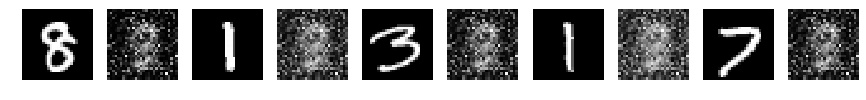

 iter: 2 batch: 4900 recon cost: 0.06565579 discrim cost: 0.25905842 fake cost: 2.311686744

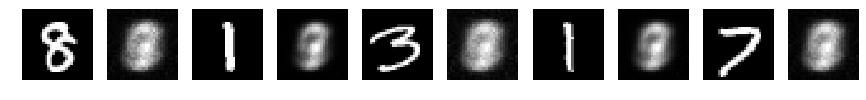

 iter: 4 batch: 4900 recon cost: 0.065015145 discrim cost: 0.21132666 fake cost: 4.2502127

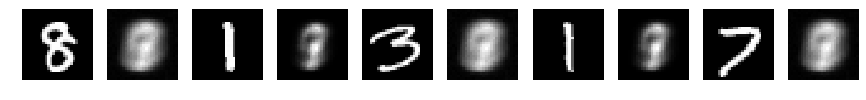

 iter: 6 batch: 4900 recon cost: 0.0643208 discrim cost: 1.8217826 fake cost: 0.2411749776

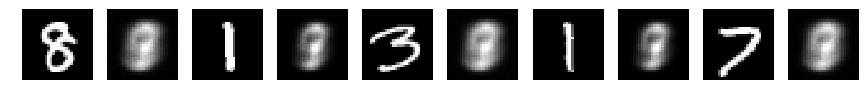

 iter: 8 batch: 4900 recon cost: 0.063403025 discrim cost: 0.41316196 fake cost: 1.7930559

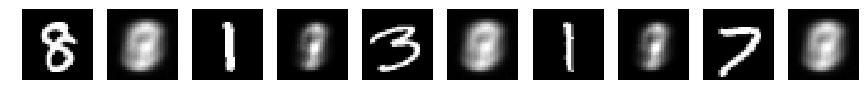

 iter: 10 batch: 4900 recon cost: 0.061825547 discrim cost: 0.86781996 fake cost: 0.45313045

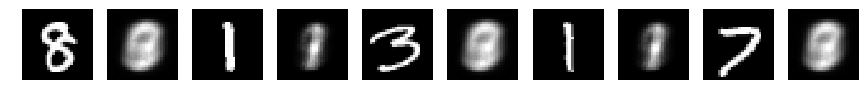

 iter: 12 batch: 4900 recon cost: 0.062091906 discrim cost: 0.21831977 fake cost: 2.44770777

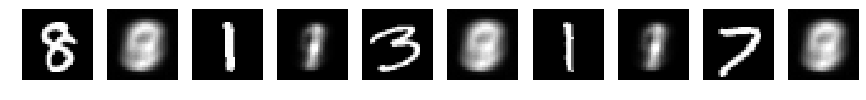

 iter: 14 batch: 4900 recon cost: 0.06113429 discrim cost: 2.332048 fake cost: 0.10259037177

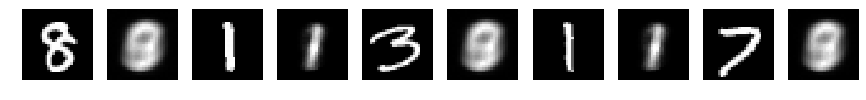

 iter: 16 batch: 4900 recon cost: 0.06083146 discrim cost: 0.30353576 fake cost: 1.89534644

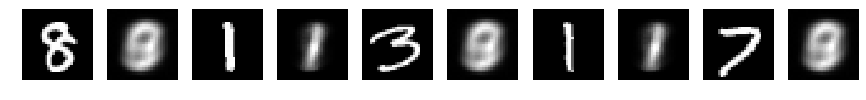

 iter: 18 batch: 4900 recon cost: 0.061334677 discrim cost: 2.1401324 fake cost: 0.056792865

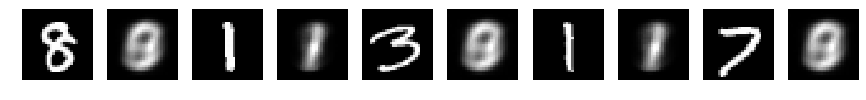

 iter: 20 batch: 4900 recon cost: 0.06390204 discrim cost: 0.6587696 fake cost: 6.3923367645

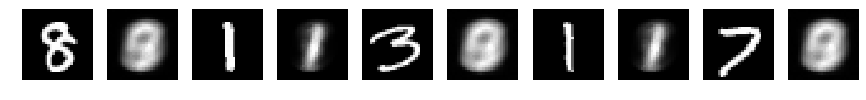

 iter: 22 batch: 4900 recon cost: 0.06123353 discrim cost: 0.40292007 fake cost: 1.07457214

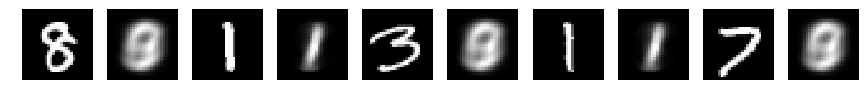

 iter: 24 batch: 4900 recon cost: 0.061538186 discrim cost: 0.9603633 fake cost: 5.311372354

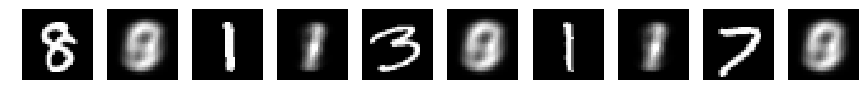

 iter: 26 batch: 4900 recon cost: 0.06093156 discrim cost: 0.18650761 fake cost: 2.37897546

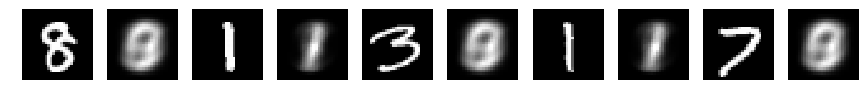

 iter: 28 batch: 4900 recon cost: 0.061219737 discrim cost: 2.579834 fake cost: 0.0345761487

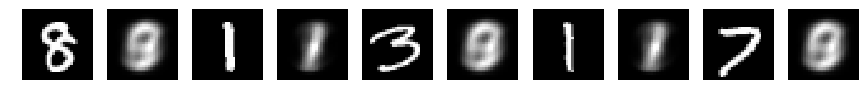

 iter: 30 batch: 4900 recon cost: 0.06229421 discrim cost: 1.1740013 fake cost: 4.7772384765

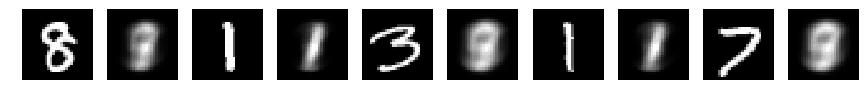

 iter: 32 batch: 4900 recon cost: 0.0615074 discrim cost: 0.6687676 fake cost: 1.1176143279

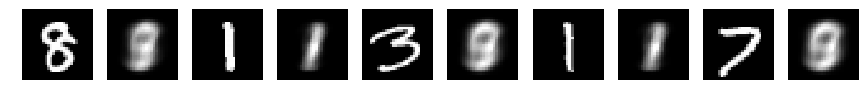

 iter: 34 batch: 4900 recon cost: 0.060731363 discrim cost: 0.6342296 fake cost: 4.422118777

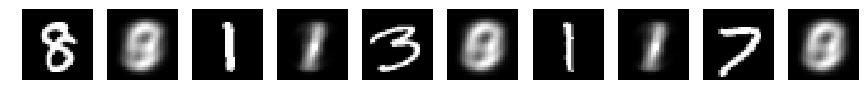

 iter: 36 batch: 4900 recon cost: 0.06087005 discrim cost: 0.10675249 fake cost: 2.865678844

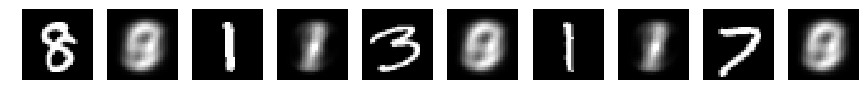

 iter: 38 batch: 4900 recon cost: 0.060384333 discrim cost: 2.782861 fake cost: 0.0448039968

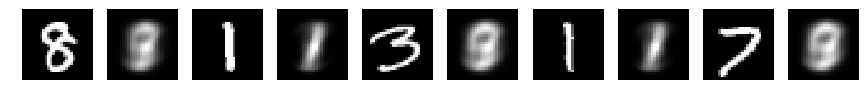

 iter: 40 batch: 4900 recon cost: 0.060942158 discrim cost: 5.2151484 fake cost: 0.0318046877

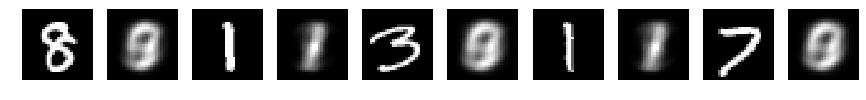

 iter: 42 batch: 4900 recon cost: 0.06519949 discrim cost: 5.7420735 fake cost: 0.088783446346

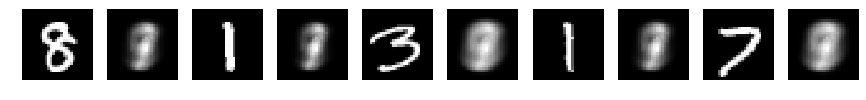

 iter: 44 batch: 4900 recon cost: 0.06236039 discrim cost: 4.021652 fake cost: 0.03050062807

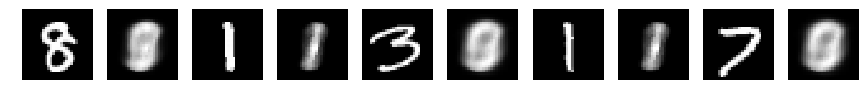

 iter: 46 batch: 4900 recon cost: 0.062279403 discrim cost: 4.5448966 fake cost: 0.001341335105

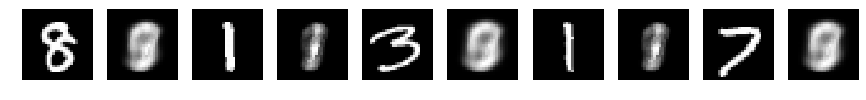

 iter: 48 batch: 4900 recon cost: 0.063493274 discrim cost: 4.611982 fake cost: -0.000100011654

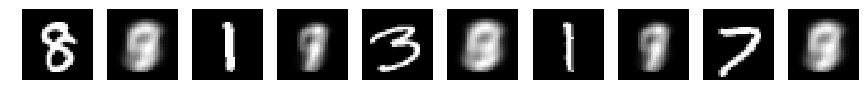

 iter: 50 batch: 4900 recon cost: 0.06291477 discrim cost: 0.43313274 fake cost: 4.5452034545

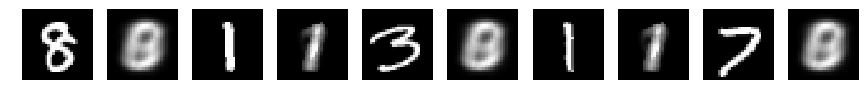

 iter: 52 batch: 4900 recon cost: 0.06432313 discrim cost: 2.5396242 fake cost: 0.542129342

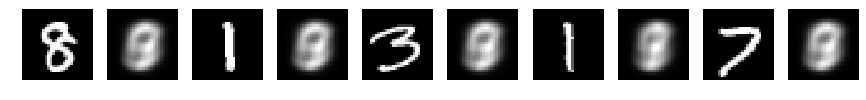

 iter: 54 batch: 4900 recon cost: 0.06273079 discrim cost: 1.3314574 fake cost: 4.322273336

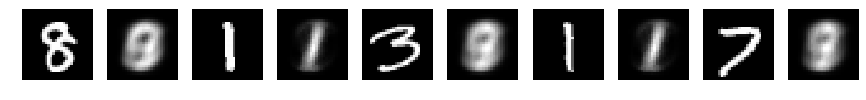

 iter: 56 batch: 4900 recon cost: 0.0611755 discrim cost: 0.49061653 fake cost: 1.691896399

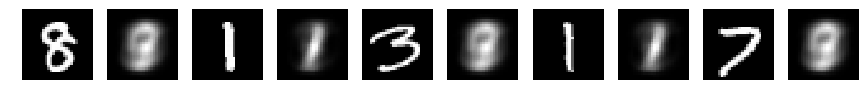

 iter: 58 batch: 4900 recon cost: 0.06162807 discrim cost: 0.3499381 fake cost: 1.665812287

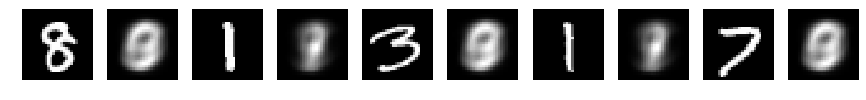

 iter: 60 batch: 4900 recon cost: 0.060743086 discrim cost: 0.376018 fake cost: 1.522788433

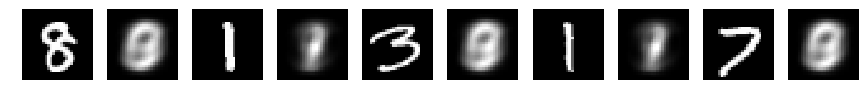

 iter: 62 batch: 4900 recon cost: 0.061149776 discrim cost: 0.35401475 fake cost: 1.5874793

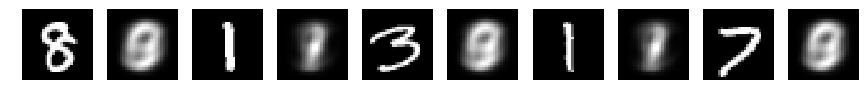

 iter: 64 batch: 4900 recon cost: 0.060523357 discrim cost: 0.3269337 fake cost: 1.58144185

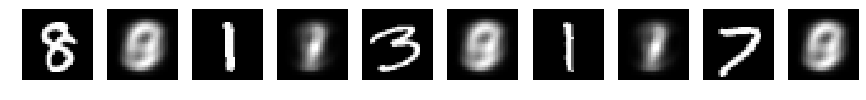

 iter: 66 batch: 4900 recon cost: 0.06007644 discrim cost: 0.31359288 fake cost: 1.59801799

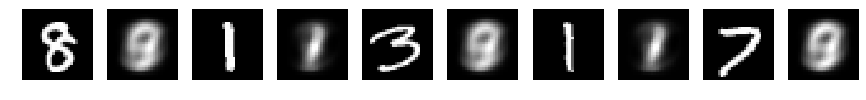

 iter: 68 batch: 4900 recon cost: 0.05970399 discrim cost: 0.3453245 fake cost: 1.632060361

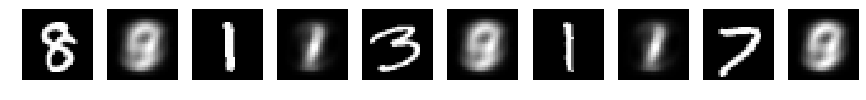

 iter: 70 batch: 4900 recon cost: 0.059417076 discrim cost: 0.33577675 fake cost: 1.6567005

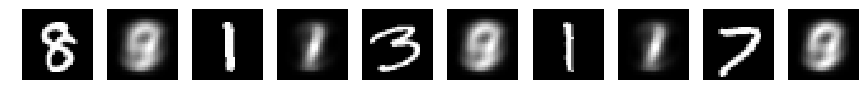

 iter: 72 batch: 4900 recon cost: 0.059038162 discrim cost: 0.31167853 fake cost: 1.6491966

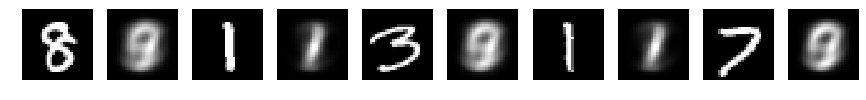

 iter: 74 batch: 4900 recon cost: 0.058979955 discrim cost: 0.31937733 fake cost: 1.6625161

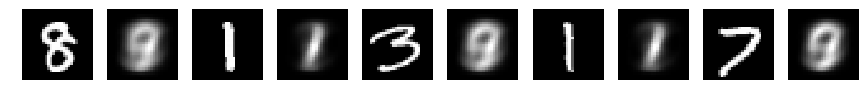

 iter: 76 batch: 4900 recon cost: 0.058709517 discrim cost: 0.31094205 fake cost: 1.6543558

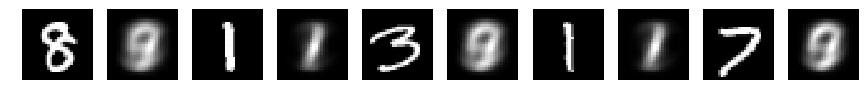

 iter: 77 batch: 1000 recon cost: 0.063854896 discrim cost: 0.30544618 fake cost: 1.895694

In [ ]:
# start the session
# sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
train_batch_shuffled = train_batch.copy()

prior_z = np.random.uniform(low=-2, high=2,size=(batch_size, 2)).astype(np.float32)

for iter in range(num_epoch):
    for current_data_index in range(0,len(train_batch),batch_size):
        current_data = train_batch_shuffled[current_data_index:current_data_index+batch_size].astype(np.float32)
        
        sess_result1 = sess.run([recon_cost,grad_update],
                    feed_dict={x:current_data.reshape((batch_size,-1))})
        sess_result2 = sess.run([discrim_cost,dis_grad_update],
                    feed_dict={dis_x:current_data.reshape((batch_size,-1)),dis_z:prior_z})
        sess_result3 = sess.run([fake_cost,fake_grad_update],
                    feed_dict={fake_x:current_data.reshape((batch_size,-1))})
        
        sys.stdout.write(
            '\r iter: ' + str(iter) + ' batch: ' + str(current_data_index) + \
            ' recon cost: ' + str(sess_result1[0]) + \
            ' discrim cost: ' + str(sess_result2[0]) + \
            ' fake cost: ' + str(sess_result3[0])

        )
        sys.stdout.flush()
        
    if iter % print_size == 0:
        sess_result = sess.run(dlayer3,feed_dict={x:current_data.reshape((batch_size,-1))}).reshape((batch_size,28,28))
        fig=plt.figure(figsize=(15, 15))
        columns = 10 ; rows = 1
        for i in range(1, columns*rows +1):
            fig.add_subplot(rows, columns, i)
            if i % 2 ==0 :
                  plt.imshow(np.squeeze(sess_result[i-2]),cmap='gray')
            else:
                plt.imshow(np.squeeze(current_data[i-1]),cmap='gray')
            plt.axis('off')
        plt.show()

In [ ]:
# convert every data into latent to know the statistics
all_latent_vectors = sess.run(elayer3,feed_dict={x:train_batch[:batch_size].reshape((batch_size,-1))})
print(train_batch.shape)
print(all_latent_vectors.shape)
for current_batch_index in range(batch_size,len(train_batch), batch_size):
    current_train_data = train_batch[current_batch_index:current_batch_index+batch_size]
    sess_results = sess.run(elayer3,feed_dict={x:current_train_data.reshape((batch_size,-1))})
    all_latent_vectors = np.vstack((all_latent_vectors,sess_results))
print(all_latent_vectors.shape)

In [ ]:
# view the latent vectors
fig = plt.figure(figsize=(10,10))
color_dict = {
    0:'red',
    1:'blue',
    2:'green',
    3:'yellow',
    4:'purple',
    5:'grey',
    6:'black',
    7:'violet',
    8:'silver',
    9:'cyan',
}
color_mapping = [color_dict[x] for x in np.argmax(train_label[:len(train_batch),:],1) ]
plt.title(str(color_dict))
plt.scatter(all_latent_vectors[:,0],all_latent_vectors[:,1],c=color_mapping)
plt.grid()
plt.show()